# Import important libraries

In [ ]:
# !pip uninstall numpy -y
# !pip install numpy
# !pip install --upgrade --no-cache-dir pmdarima

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Load the dataset

In [ ]:
#Read the csv file
df = pd.read_csv('Final_nflx_data_2018-2022.csv')
df['date'] = pd.to_datetime(df['date'])
df

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count
0,2018-01-02,196.100006,201.649994,195.419998,201.070007,201.070007,10966900,0.020833,10,480
1,2018-01-03,202.050003,206.210007,201.500000,205.050003,205.050003,8591400,0.071217,24,337
2,2018-01-04,206.199997,207.050003,204.000000,205.630005,205.630005,6029600,-0.018519,-4,216
3,2018-01-05,207.250000,210.020004,205.589996,209.990005,209.990005,7033200,-0.019737,-6,304
4,2018-01-08,210.020004,212.500000,208.440002,212.050003,212.050003,5580200,-0.007663,-2,261
...,...,...,...,...,...,...,...,...,...,...
1132,2022-07-01,176.490005,180.100006,174.270004,179.949997,179.949997,5194700,-0.062315,-21,337
1133,2022-07-05,176.279999,185.919998,172.679993,185.880005,185.880005,7334300,-0.058824,-25,425
1134,2022-07-06,185.199997,186.220001,180.820007,184.059998,184.059998,5753400,-0.014870,-8,538
1135,2022-07-07,184.270004,190.210007,183.500000,189.270004,189.270004,6334500,-0.055427,-24,433


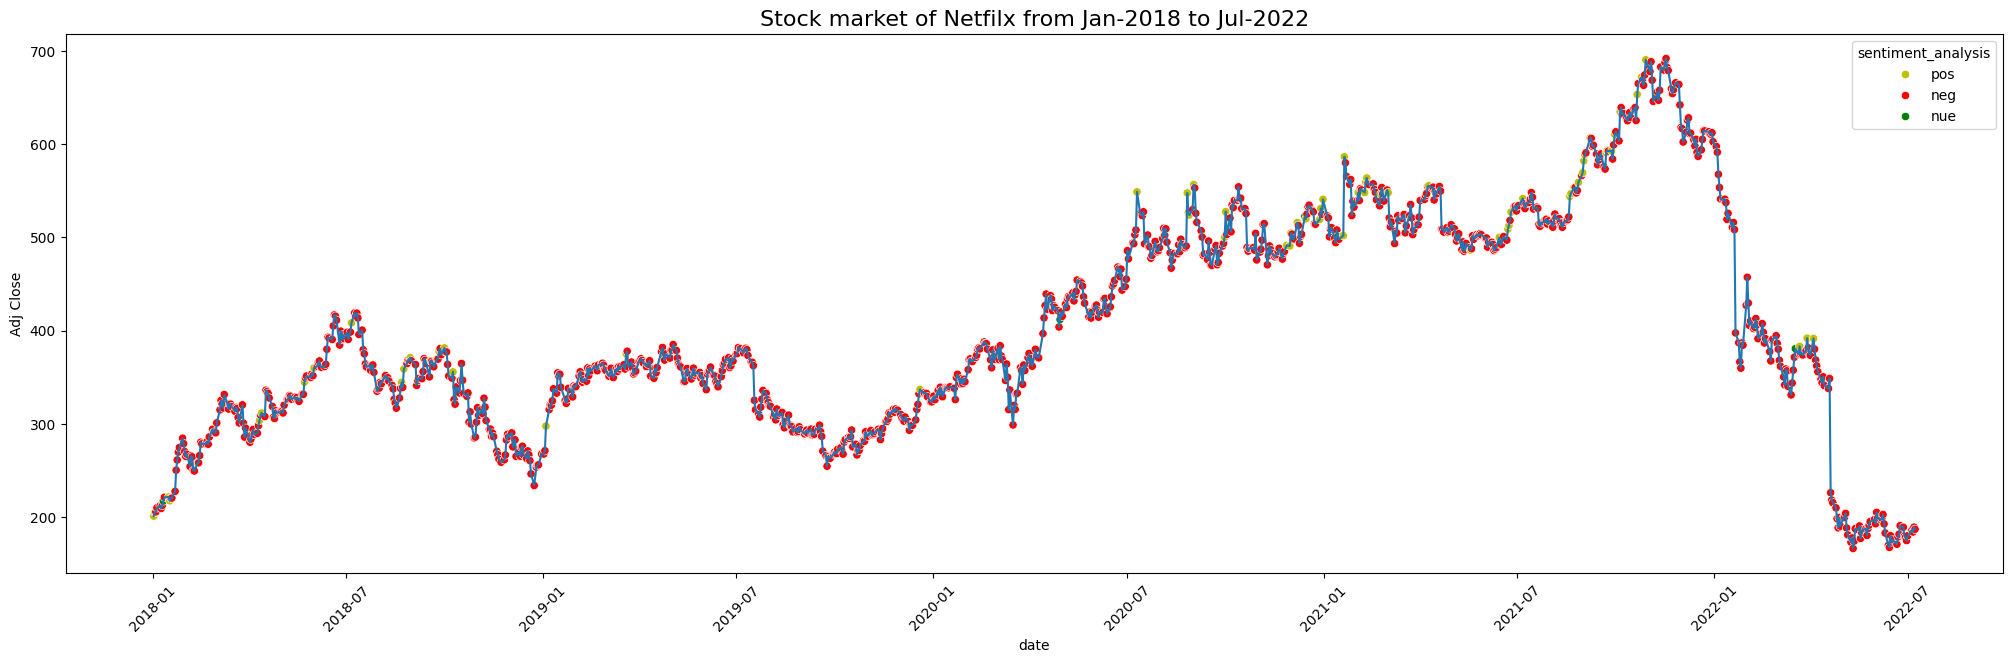

In [ ]:
import seaborn as sns
plt.figure(figsize=(25,7));
sns.lineplot(x=df["date"],y=df["Adj Close"])
df['sentiment_analysis']=df['P_mean']
df['sentiment_analysis']=df['sentiment_analysis'].apply(lambda x: 'pos' if x>0 else 'nue' if x==0 else 'neg')
sns.scatterplot(x=df["date"],y=df['Adj Close'],hue=df['sentiment_analysis'],palette=['y','r','g'])
plt.xticks(rotation=45);
plt.title("Stock market of Netfilx from Jan-2018 to Jul-2022",fontsize=16);

In [ ]:
df['sentiment_analysis'].value_counts()

,count
sentiment_analysis,
neg,1059
pos,71
nue,7


In [ ]:
df=df.drop(list(range(14)),axis=0,inplace=False)
df

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count,sentiment_analysis
14,2018-01-23,255.050003,257.709991,248.020004,250.289993,250.289993,27705300,-0.061196,-88,1438,neg
15,2018-01-24,250.880005,261.709991,249.309998,261.299988,261.299988,17352400,-0.084525,-65,769,neg
16,2018-01-25,263.000000,272.299988,260.230011,269.700012,269.700012,15336400,-0.122744,-102,831,neg
17,2018-01-26,271.489990,274.600006,268.760010,274.600006,274.600006,11021800,-0.118012,-57,483,neg
18,2018-01-29,274.200012,286.809998,273.920013,284.589996,284.589996,17529700,-0.100690,-73,725,neg
...,...,...,...,...,...,...,...,...,...,...,...
1132,2022-07-01,176.490005,180.100006,174.270004,179.949997,179.949997,5194700,-0.062315,-21,337,neg
1133,2022-07-05,176.279999,185.919998,172.679993,185.880005,185.880005,7334300,-0.058824,-25,425,neg
1134,2022-07-06,185.199997,186.220001,180.820007,184.059998,184.059998,5753400,-0.014870,-8,538,neg
1135,2022-07-07,184.270004,190.210007,183.500000,189.270004,189.270004,6334500,-0.055427,-24,433,neg


In [ ]:
def load_and_preprocess_data(file_path):
    """
    Load and preprocess the stock market dataset
    """
    # Read the CSV file
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])

    # Drop first 14 rows
    df = df.drop(list(range(14)), axis=0, inplace=False)

    # Columns for training
    cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'P_mean']

    # Create dataframe for training
    df_for_training = df[cols].astype(float)
    df_for_training.index = df['date']

    return df, df_for_training

In [ ]:
def visualize_stock_data(df):
    """
    Visualize stock data and sentiment analysis
    """
    plt.figure(figsize=(25,7))
    sns.lineplot(x=df["date"], y=df["Adj Close"])

    # Sentiment analysis visualization
    df['sentiment_analysis'] = df['P_mean'].apply(lambda x: 'pos' if x>0 else 'nue' if x==0 else 'neg')
    plt.figure(figsize=(25,7))
    sns.scatterplot(x=df["date"], y=df['Adj Close'], hue=df['sentiment_analysis'], palette=['y','r','g'])
    plt.xticks(rotation=45)
    plt.title("Stock market of Netflix from Jan-2018 to Jul-2022", fontsize=16)
    plt.show()

    print(df['sentiment_analysis'].value_counts())

In [ ]:
def prepare_lstm_data(df_for_training, n_past=5, n_future=1):
    """
    Prepare data for LSTM training
    """
    # Scale the data
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df_for_training)
    scaler_for_inference = MinMaxScaler()
    scaler_for_inference.fit_transform(df_for_training.loc[:,['Open','Adj Close']])

    # Prepare sequences
    trainX, trainY = [], []
    for i in range(n_past, len(df_scaled) - n_future + 1):
        trainX.append(df_scaled[i - n_past:i, 0:df_for_training.shape[1]])
        trainY.append(df_scaled[i + n_future - 1:i + n_future, [0, -2]])

    trainX, trainY = np.array(trainX), np.array(trainY)

    return trainX, trainY, scaler_for_inference

In [ ]:
class CNNLSTMModel(nn.Module):
    """
    PyTorch CNN-LSTM Model
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(CNNLSTMModel, self).__init__()

        # 1D Convolutional Layers
        self.conv1 = nn.Conv1d(input_size, 128, kernel_size=2, stride=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(128, 64, kernel_size=2, stride=1)
        self.pool2 = nn.MaxPool1d(kernel_size=1, stride=2)

        # Bidirectional LSTM Layers
        self.lstm = nn.LSTM(64, hidden_size, num_layers,
                            batch_first=True, bidirectional=True, dropout=0.2)

        # Dense Layers
        self.fc1 = nn.Linear(hidden_size * 2, 32)
        self.fc2 = nn.Linear(32, output_size)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Convolutional Layers
        x = x.permute(0, 2, 1)  # Adjust for 1D convolution
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))

        # Prepare for LSTM
        x = x.permute(0, 2, 1)

        # LSTM Layer
        lstm_out, _ = self.lstm(x)

        # Take the last time step
        x = lstm_out[:, -1, :]

        # Dense Layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=64):
    """
    Train the PyTorch model
    """
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Loss and Optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    # Training loop
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_epoch_loss = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.view(outputs.shape))
            loss.backward()
            optimizer.step()
            train_epoch_loss += loss.item()

        # Validation
        model.eval()
        val_epoch_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y.view(outputs.shape))
                val_epoch_loss += loss.item()

        train_losses.append(train_epoch_loss / len(train_loader))
        val_losses.append(val_epoch_loss / len(val_loader))

        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}')

    # Plot training and validation loss
    plt.figure(figsize=(20,5))
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.title('Training loss Vs. Validation loss')
    plt.legend()
    plt.show()

    return train_losses, val_losses

In [ ]:
def plot_predictions(dates, y_actual, y_pred, title, predicted_features=['Open', 'Adj Close']):
    """
    Plot predictions with actual values
    """
    for i, feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        plt.title(f'{title} prediction of {feature} feature')
        plt.plot(dates, y_actual[:,i], label='Actual')
        plt.plot(dates, y_pred[:, i], label='Predicted')
        plt.legend()
        plt.show()

        # Calculate and print MSE
        mse = mean_squared_error(y_actual[:,i], y_pred[:, i])
        print(f'Mean square error for {feature} = {mse}')

    # Total MSE
    total_mse = mean_squared_error(y_actual, y_pred)
    print('Total mean square error', total_mse)

In [ ]:
def predict_and_evaluate(model, X_data, y_data, scaler_for_inference, dates, data_type, with_twitter=False):
    """
    Perform predictions and evaluate model performance

    Parameters:
    - model: Trained PyTorch model
    - X_data: Input features
    - y_data: Actual target values
    - scaler_for_inference: Scaler for inverse transformation
    - dates: Corresponding dates for the data
    - data_type: 'Training', 'Validation', or 'Testing'
    - with_twitter: Whether twitter sentiment was included
    """
    # Convert to PyTorch tensor
    X_tensor = torch.FloatTensor(X_data)

    # Set model to evaluation mode
    model.eval()

    # Make predictions
    with torch.no_grad():
        predictions = model(X_tensor).numpy()

    # Reshape predictions
    predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])

    # Inverse transform predictions and actual values
    y_pred = scaler_for_inference.inverse_transform(predictions)
    y_actual = scaler_for_inference.inverse_transform(
        y_data.reshape(y_data.shape[0], y_data.shape[2])
    )

    # Plot predictions
    plt.figure(figsize=(20,6))
    title = f'{data_type} Prediction {"with" if with_twitter else "without"} Twitter Sentiment'
    plot_predictions(dates, y_actual, y_pred, title)

    return y_actual, y_pred

In [ ]:
def save_model(model, model_name):
    """
    Save a PyTorch model to disk

    Parameters:
    - model: The trained PyTorch model
    - model_name: Name for the saved model file
    """
    # Save the entire model
    torch.save(model, f'{model_name}.pt')
    print(f"Model saved as {model_name}.pt")

    # Alternatively, save just the model state dictionary (smaller file size)
    torch.save(model.state_dict(), f'{model_name}_state_dict.pt')
    print(f"Model state dictionary saved as {model_name}_state_dict.pt")

In [ ]:
def load_model(model_path, model_class=None):
    """
    Load a PyTorch model from disk

    Parameters:
    - model_path: Path to the saved model file
    - model_class: Class of the model (needed only for loading state_dict)

    Returns:
    - Loaded model
    """
    if model_path.endswith('_state_dict.pt'):
        # Load just the state dictionary
        if model_class is None:
            raise ValueError("model_class must be provided to load state_dict")

        # Initialize model with the same architecture
        model = model_class()
        model.load_state_dict(torch.load(model_path))
        return model
    else:
        # Load the entire model
        return torch.load(model_path)

In [ ]:
def main():
    # File path (replace with your actual file path)
    file_path = 'Final_nflx_data_2018-2022.csv' # /content/Final_nflx_data_2018-2022.csv

    # Load and preprocess data
    df, df_for_training = load_and_preprocess_data(file_path)

    # Visualize stock data
    visualize_stock_data(df)

    # Prepare data for LSTM
    trainX, trainY, scaler_for_inference = prepare_lstm_data(df_for_training)

    # Split data
    X_train_without_twitter, X_test_without_twitter, y_train_without_twitter, y_test_without_twitter = train_test_split(
        trainX[:,:,:-1], trainY, test_size=0.2, shuffle=False
    )

    X_train_twitter, X_test_twitter, y_train_twitter, y_test_twitter = train_test_split(
        trainX, trainY, test_size=0.2, shuffle=False
    )

    # Further split for validation
    X_train_without_twitter, X_val_without_twitter, y_train_without_twitter, y_val_without_twitter = train_test_split(
        X_train_without_twitter, y_train_without_twitter, test_size=0.1, shuffle=False
    )

    X_train_twitter, X_val_twitter, y_train_twitter, y_val_twitter = train_test_split(
        X_train_twitter, y_train_twitter, test_size=0.1, shuffle=False
    )

    # Initialize models
    model_without_twitter = CNNLSTMModel(
        input_size=X_train_without_twitter.shape[2],
        hidden_size=256,
        num_layers=2,
        output_size=trainY.shape[2]
    )

    model_twitter = CNNLSTMModel(
        input_size=X_train_twitter.shape[2],
        hidden_size=256,
        num_layers=2,
        output_size=trainY.shape[2]
    )

    # Train models
    train_losses_without_twitter, val_losses_without_twitter = train_model(
        model_without_twitter,
        X_train_without_twitter,
        y_train_without_twitter,
        X_val_without_twitter,
        y_val_without_twitter
    )

    train_losses_twitter, val_losses_twitter = train_model(
        model_twitter,
        X_train_twitter,
        y_train_twitter,
        X_val_twitter,
        y_val_twitter
    )

    # Save the trained models
    save_model(model_without_twitter, "stock_model_without_twitter")
    save_model(model_twitter, "stock_model_with_twitter")

    # Training Dates and Predictions
    training_dates = df_for_training.index[:X_train_without_twitter.shape[0]]

    # Predictions without Twitter
    y_train_actual_without_twitter, y_train_pred_without_twitter = predict_and_evaluate(
        model_without_twitter,
        X_train_without_twitter,
        y_train_without_twitter,
        scaler_for_inference,
        training_dates,
        'Training',
        with_twitter=False
    )

    # Predictions with Twitter
    y_train_actual_twitter, y_train_pred_twitter = predict_and_evaluate(
        model_twitter,
        X_train_twitter,
        y_train_twitter,
        scaler_for_inference,
        training_dates,
        'Training',
        with_twitter=True
    )

    # Validation Dates and Predictions
    validation_dates = df_for_training.index[
        X_train_without_twitter.shape[0]:X_train_without_twitter.shape[0] + X_val_without_twitter.shape[0]
    ]

    # Predictions without Twitter
    y_val_actual_without_twitter, y_val_pred_without_twitter = predict_and_evaluate(
        model_without_twitter,
        X_val_without_twitter,
        y_val_without_twitter,
        scaler_for_inference,
        validation_dates,
        'Validation',
        with_twitter=False
    )

    # Predictions with Twitter
    y_val_actual_twitter, y_val_pred_twitter = predict_and_evaluate(
        model_twitter,
        X_val_twitter,
        y_val_twitter,
        scaler_for_inference,
        validation_dates,
        'Validation',
        with_twitter=True
    )

    # Testing Dates and Predictions
    testing_dates = df_for_training.index[-X_test_without_twitter.shape[0]:]

    # Predictions without Twitter
    y_test_actual_without_twitter, y_test_pred_without_twitter = predict_and_evaluate(
        model_without_twitter,
        X_test_without_twitter,
        y_test_without_twitter,
        scaler_for_inference,
        testing_dates,
        'Testing',
        with_twitter=False
    )

    # Predictions with Twitter
    y_test_actual_twitter, y_test_pred_twitter = predict_and_evaluate(
        model_twitter,
        X_test_twitter,
        y_test_twitter,
        scaler_for_inference,
        testing_dates,
        'Testing',
        with_twitter=True
    )

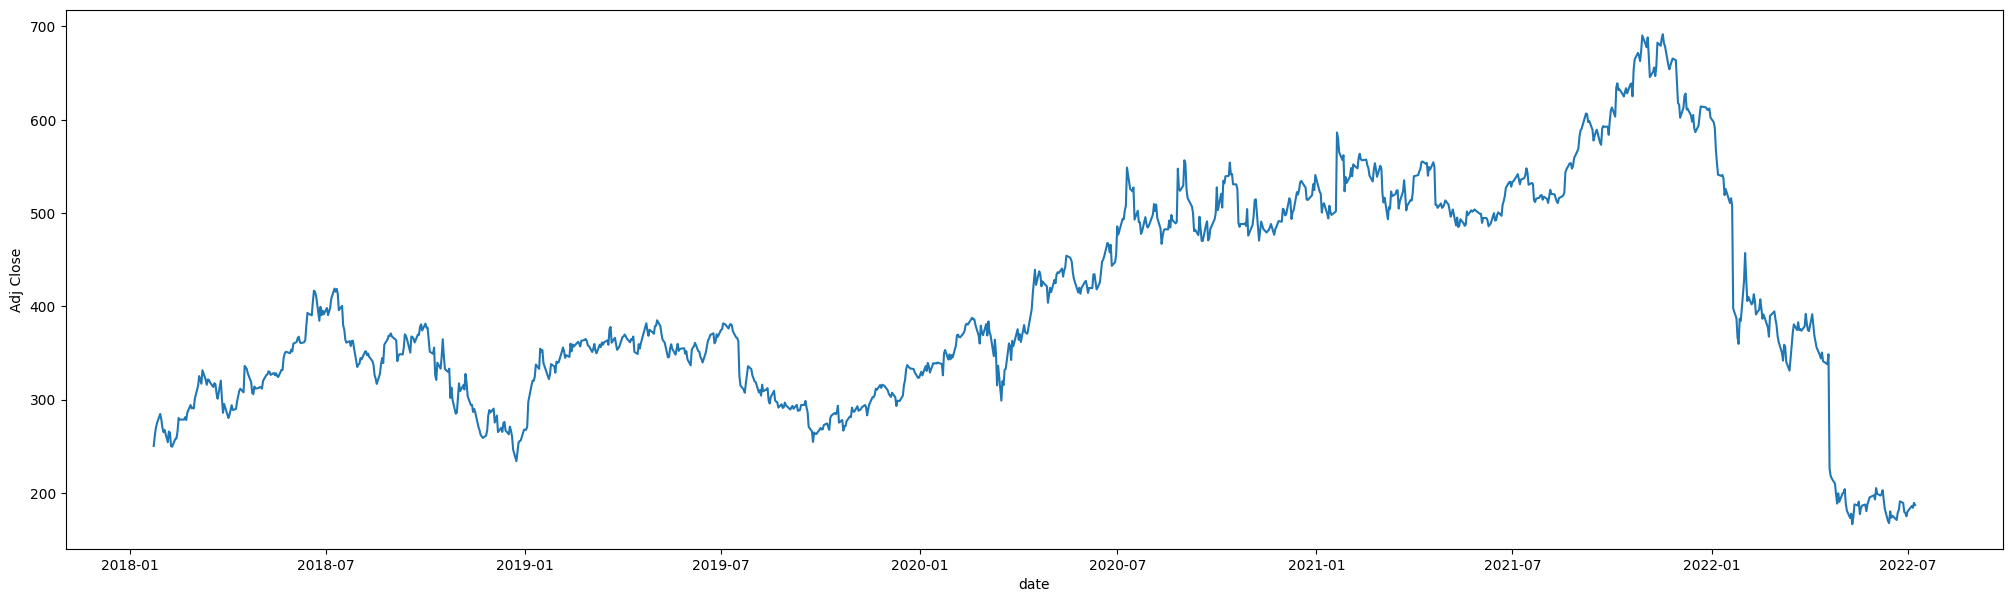

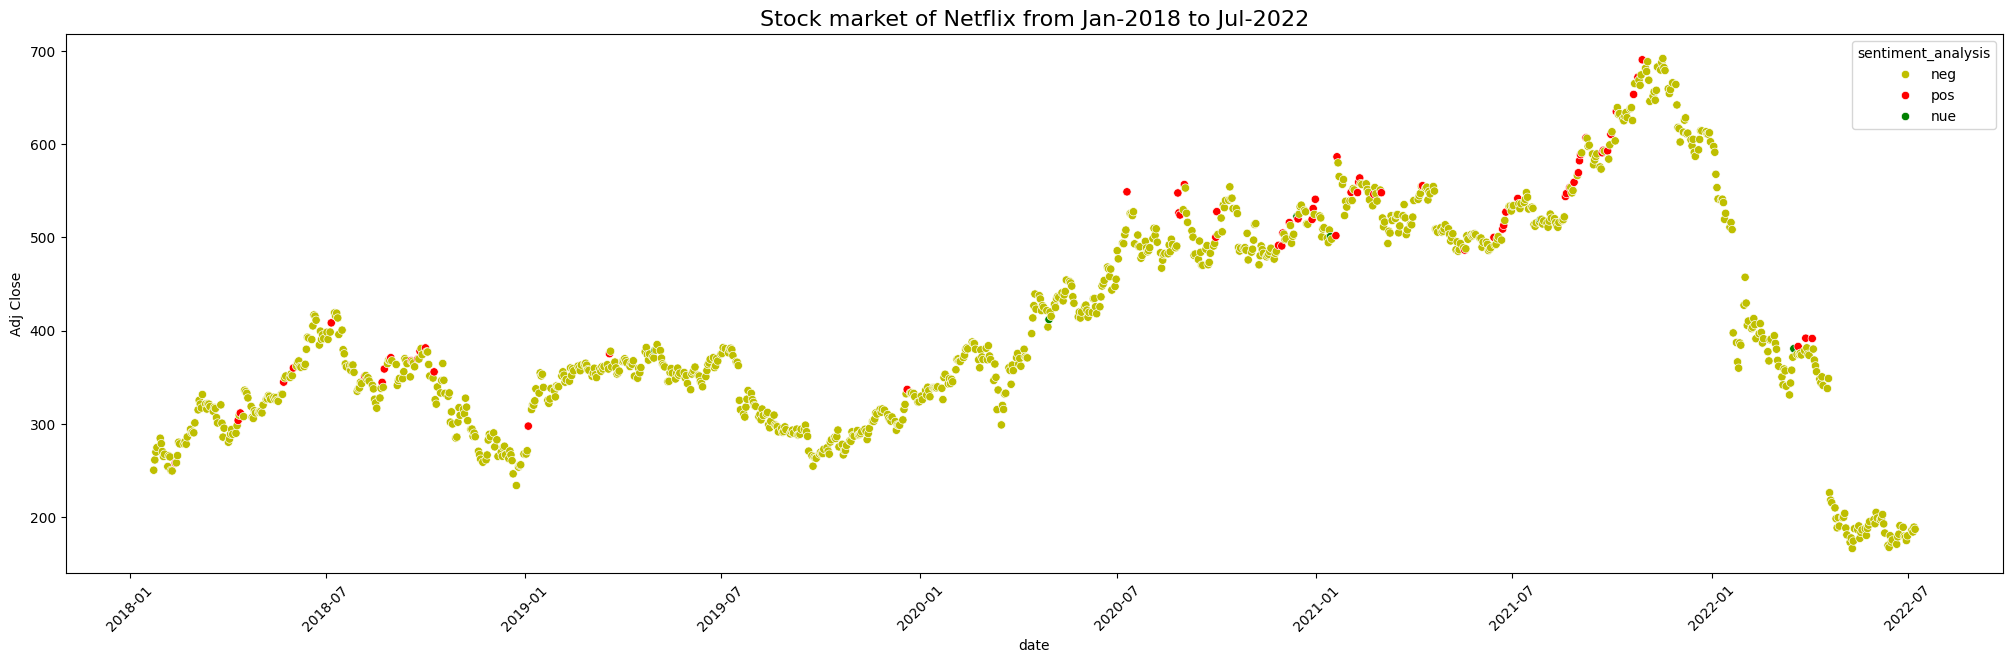

sentiment_analysis
neg    1050
pos      67
nue       6
Name: count, dtype: int64
Epoch 0: Train Loss = 0.26169126538129955, Val Loss = 0.2957703024148941
Epoch 10: Train Loss = 0.0019012545772756522, Val Loss = 0.0004215687222313136
Epoch 20: Train Loss = 0.0014267959475266533, Val Loss = 0.0025300306733697653
Epoch 30: Train Loss = 0.006692851949572707, Val Loss = 0.015168558340519667
Epoch 40: Train Loss = 0.003787169884442567, Val Loss = 0.00325799104757607


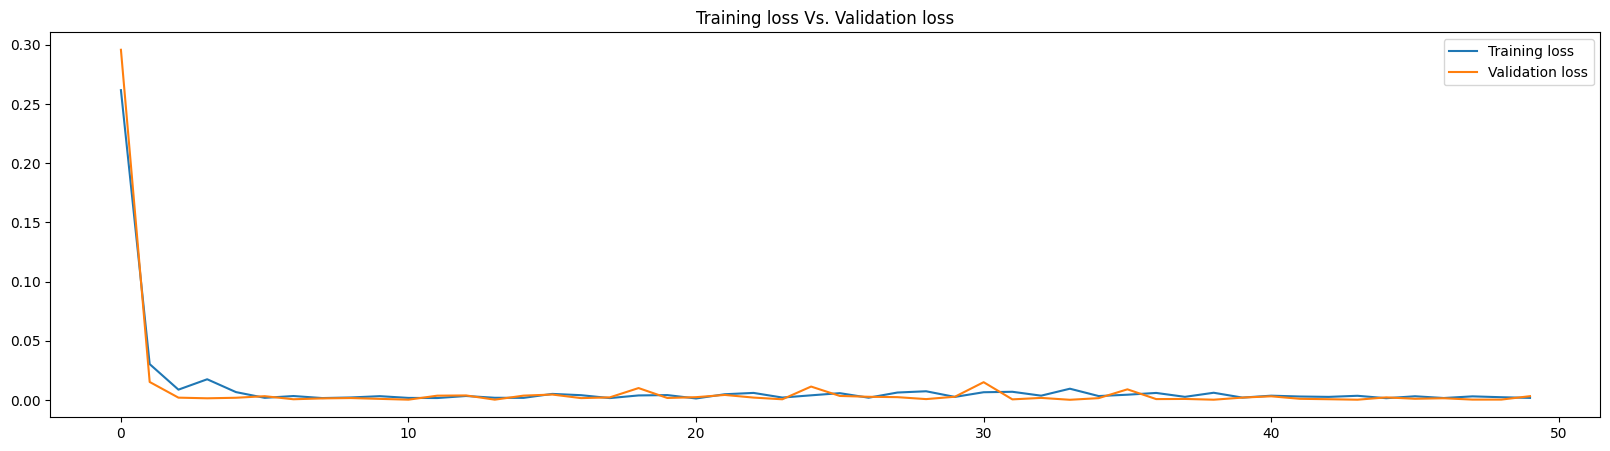

Epoch 0: Train Loss = 0.09799509911009899, Val Loss = 0.03653225488960743
Epoch 10: Train Loss = 0.0015287780887984599, Val Loss = 0.002027797745540738
Epoch 20: Train Loss = 0.004983684072682921, Val Loss = 0.016210488975048065
Epoch 30: Train Loss = 0.003584970532056804, Val Loss = 0.002193983062170446
Epoch 40: Train Loss = 0.0029677741560870064, Val Loss = 0.0004675349046010524


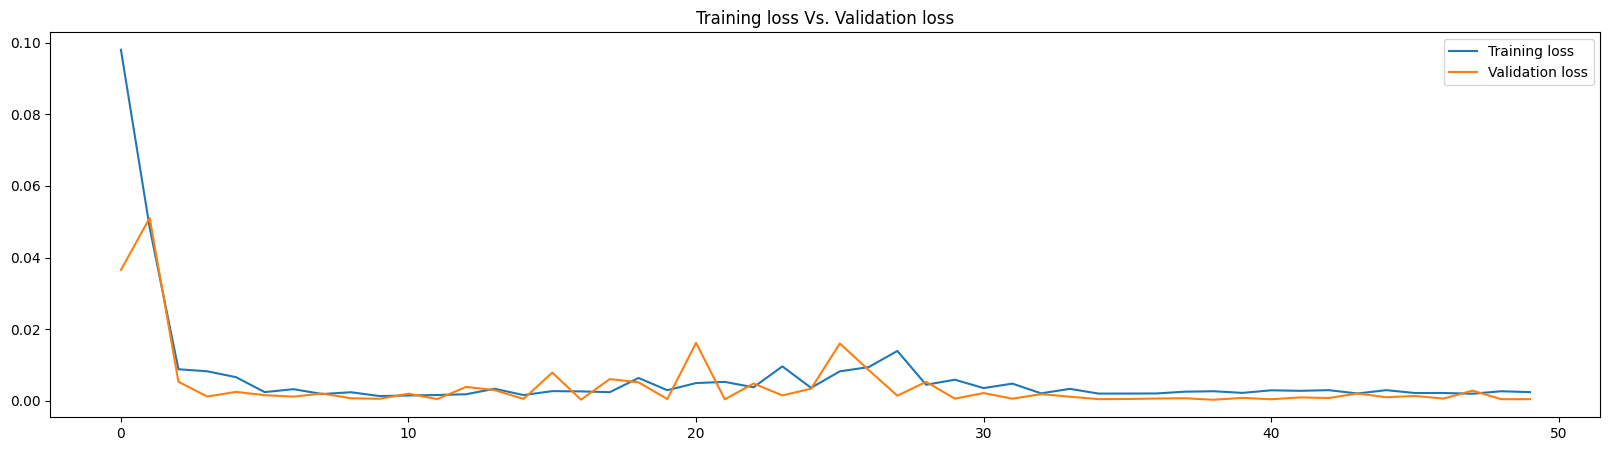

Model saved as stock_model_without_twitter.pt
Model state dictionary saved as stock_model_without_twitter_state_dict.pt
Model saved as stock_model_with_twitter.pt
Model state dictionary saved as stock_model_with_twitter_state_dict.pt


<Figure size 2000x600 with 0 Axes>

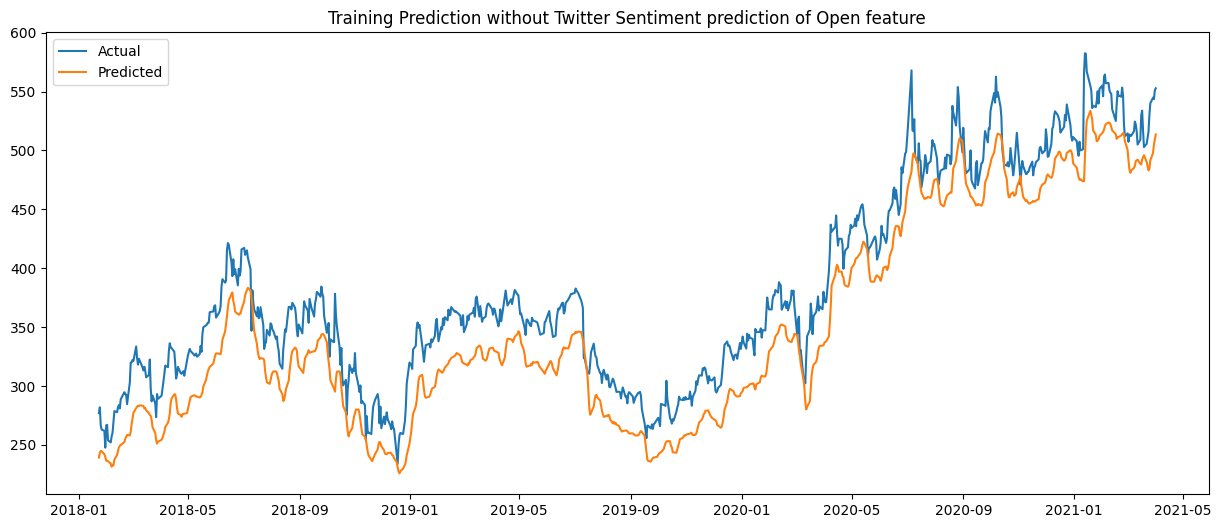

Mean square error for Open = 1260.2105371191733


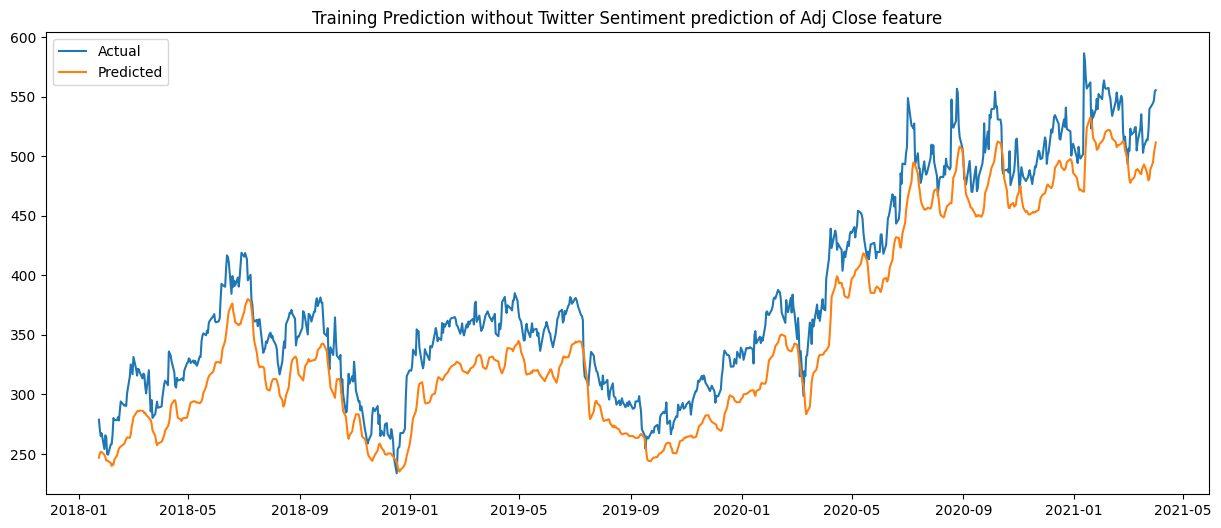

Mean square error for Adj Close = 1280.1352358507909
Total mean square error 1270.172886484982


<Figure size 2000x600 with 0 Axes>

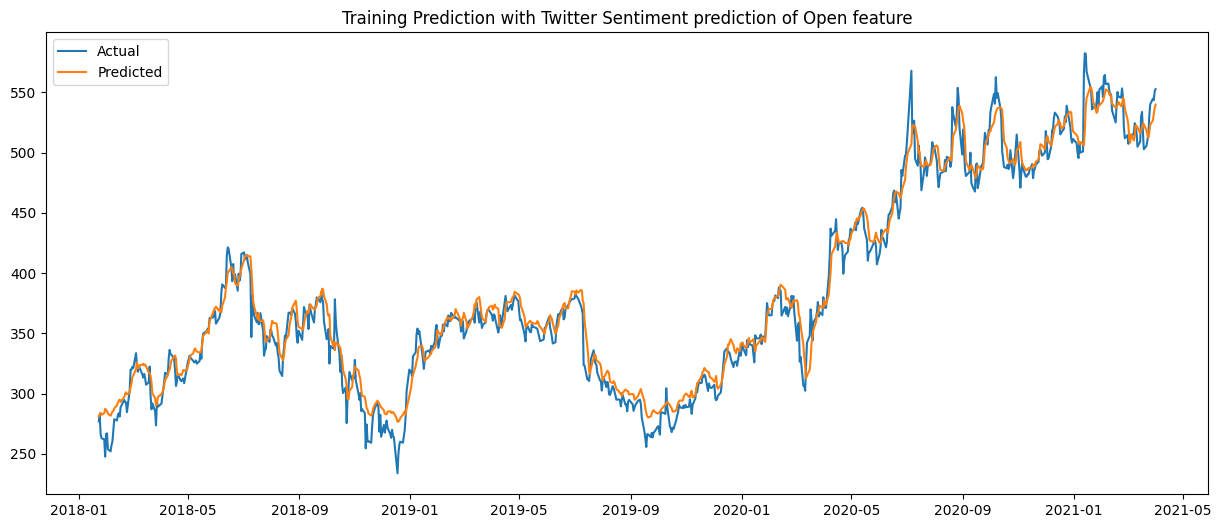

Mean square error for Open = 177.30145278198162


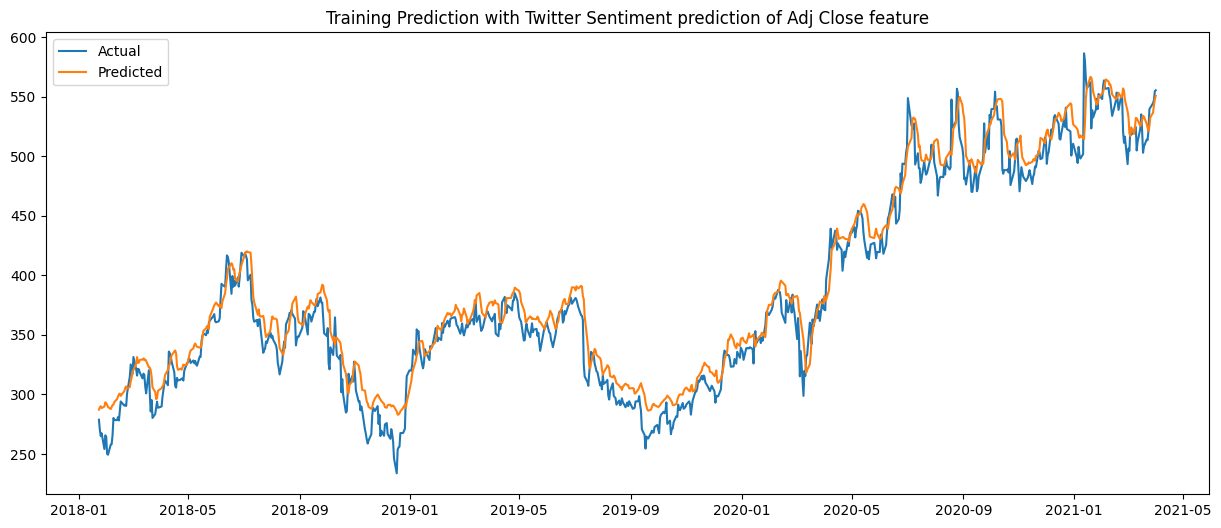

Mean square error for Adj Close = 303.7824180288148
Total mean square error 240.54193540539836


<Figure size 2000x600 with 0 Axes>

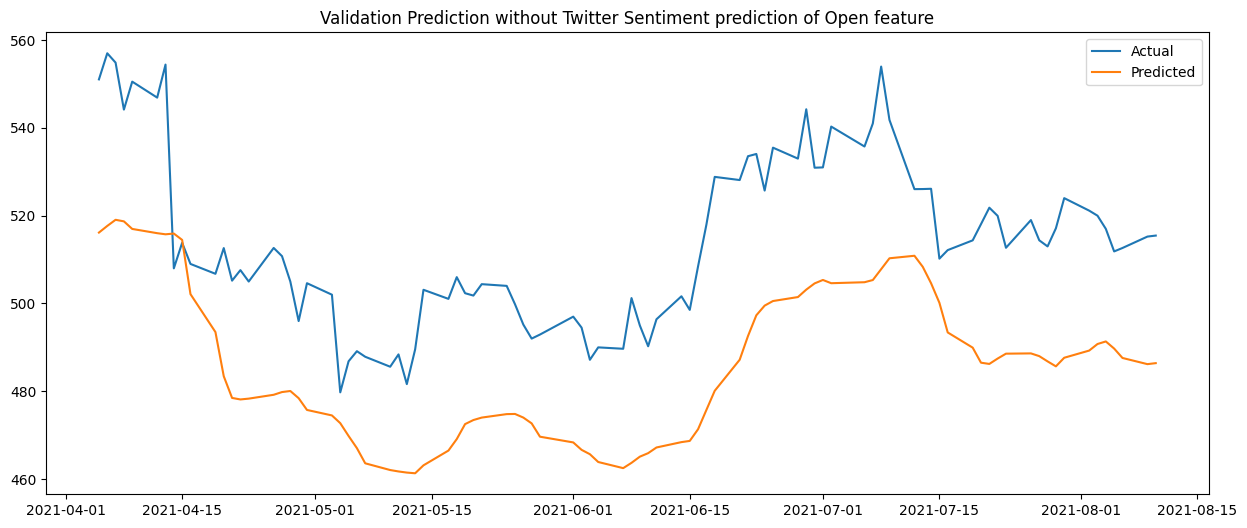

Mean square error for Open = 863.8113993358731


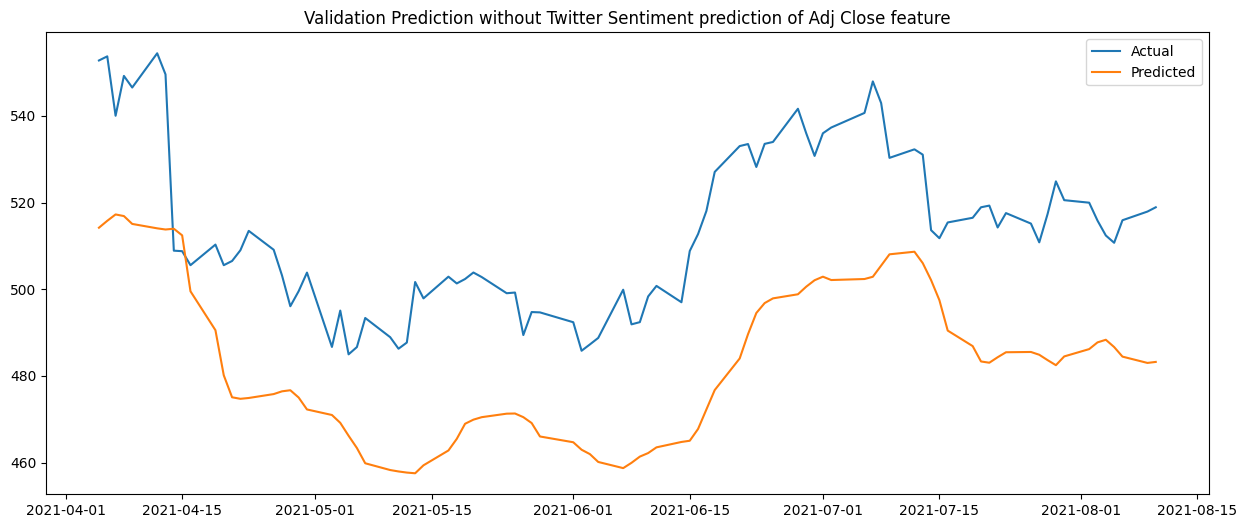

Mean square error for Adj Close = 1043.4386064659413
Total mean square error 953.6250029009069


<Figure size 2000x600 with 0 Axes>

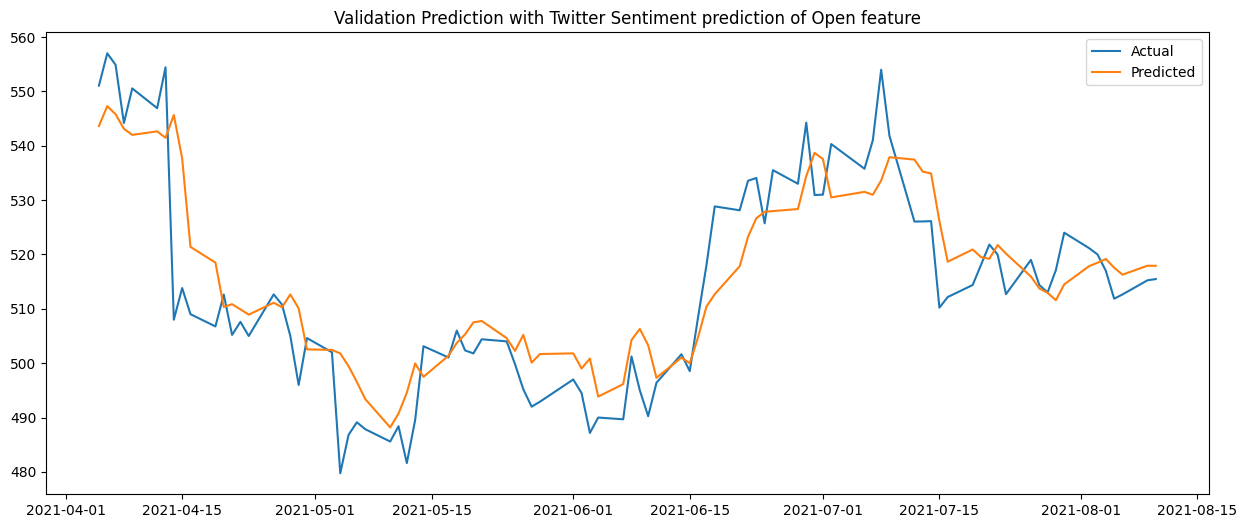

Mean square error for Open = 83.09652068919064


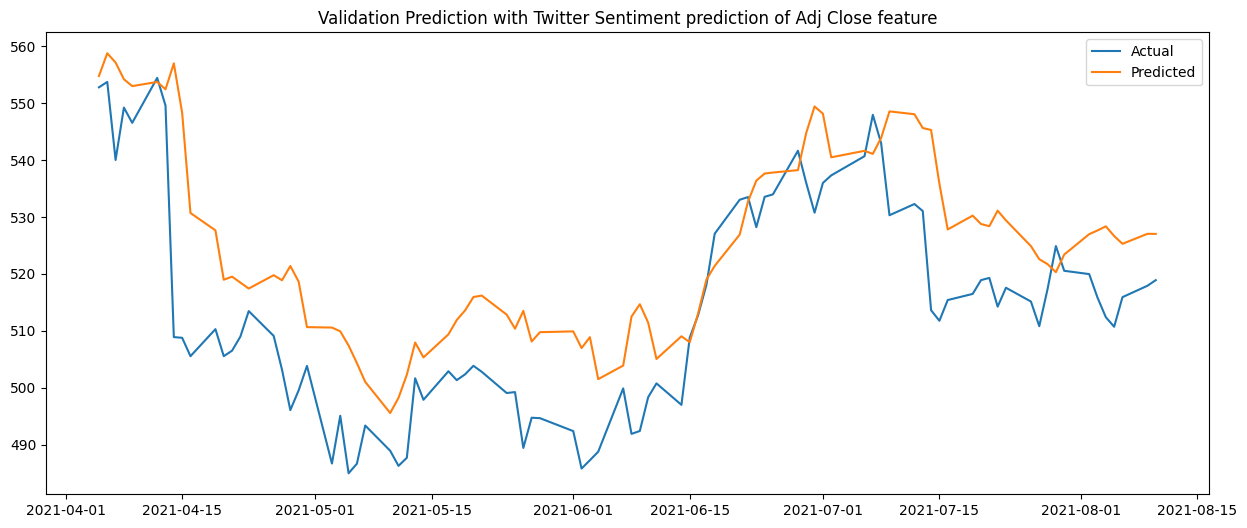

Mean square error for Adj Close = 212.76816131424215
Total mean square error 147.9323410017164


<Figure size 2000x600 with 0 Axes>

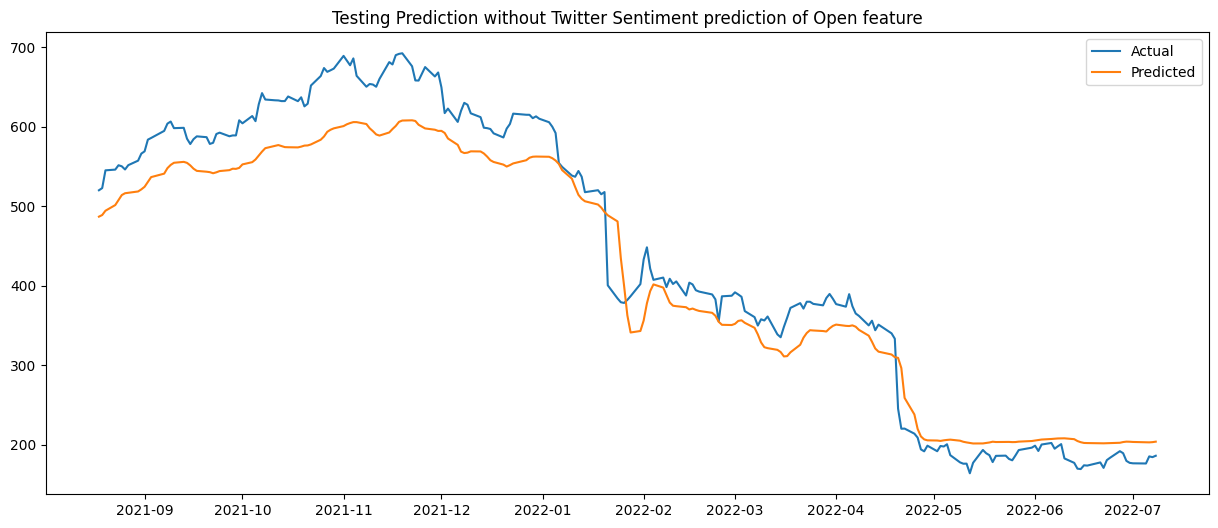

Mean square error for Open = 1924.761455408327


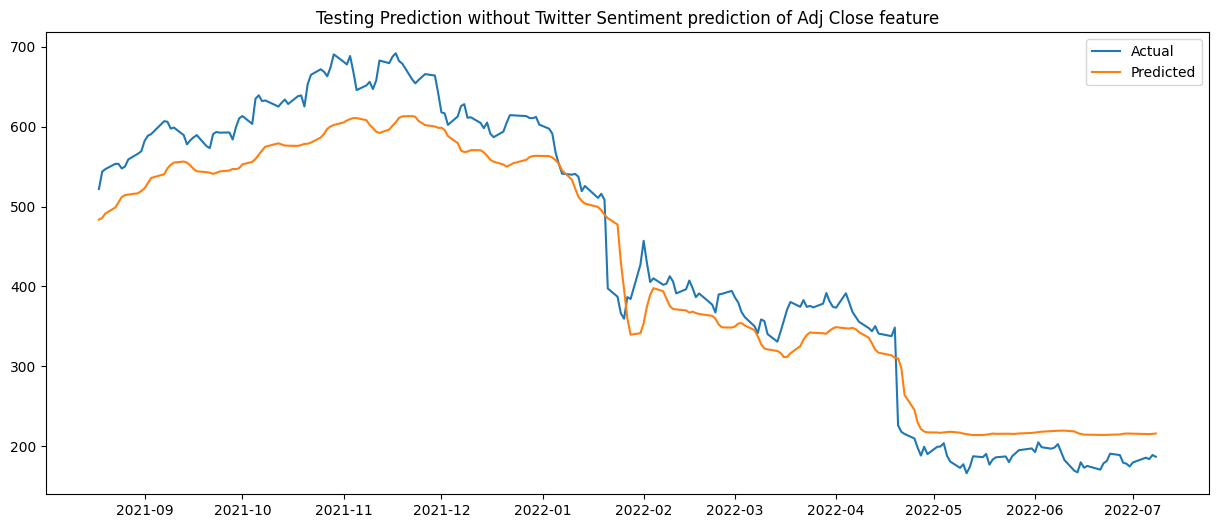

Mean square error for Adj Close = 2061.2479938380825
Total mean square error 1993.0047246232048


<Figure size 2000x600 with 0 Axes>

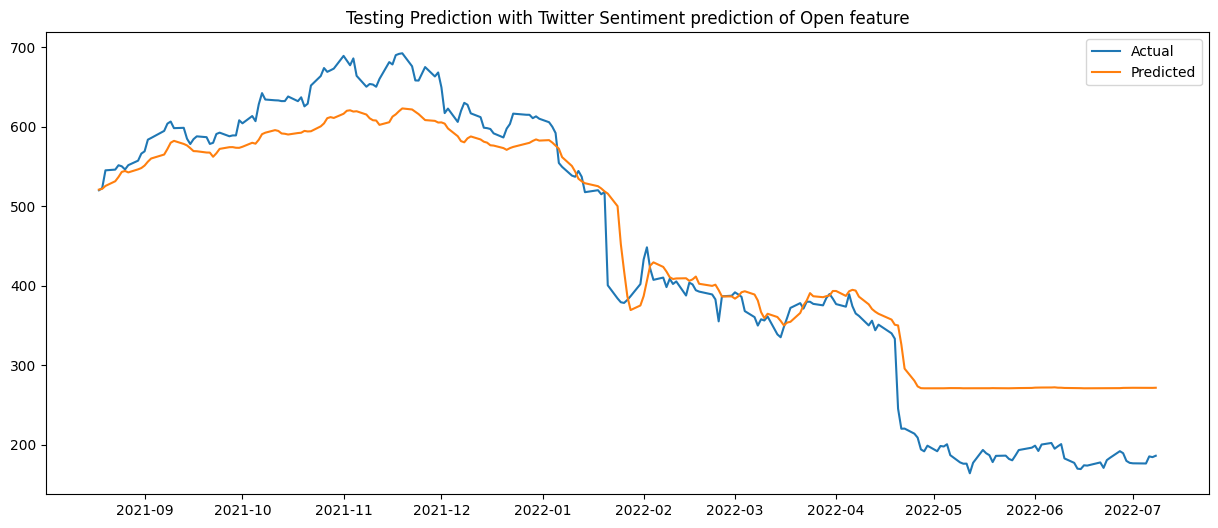

Mean square error for Open = 2729.5029386548704


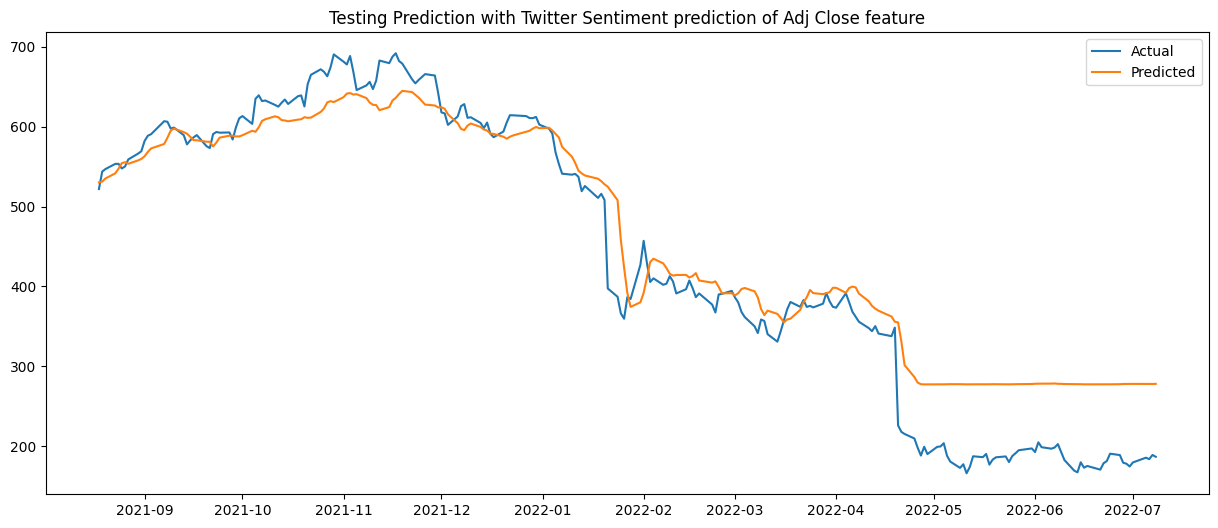

Mean square error for Adj Close = 2775.357417832159
Total mean square error 2752.430178243515


In [ ]:
if __name__ == "__main__":
    main()